In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc, roc_auc_score, ConfusionMatrixDisplay,f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

#import sqlalchemy
#import snowflake.connector
#from sqlalchemy import create_engine
#from snowflake.sqlalchemy import *
#import src.snowflake_creds as snowflake_creds
import warnings
warnings.filterwarnings('ignore')

In [ ]:
cd 'drive/MyDrive'

/content/drive/MyDrive


In [ ]:
data = pd.read_csv('KaggleV2-May-2016.csv')

In [ ]:
data.shape

(110527, 14)

In [ ]:
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [ ]:
data.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [ ]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [ ]:
data['No-show'].value_counts()

No-show
No     88208
Yes    22319
Name: count, dtype: int64

In [ ]:
data['No-show'].replace('Yes',1,inplace=True)
data['No-show'].replace('No',0,inplace=True)

In [ ]:
data['No-show'].groupby(data['SMS_received']).value_counts()

SMS_received  No-show
0             0          62510
              1          12535
1             0          25698
              1           9784
Name: count, dtype: int64

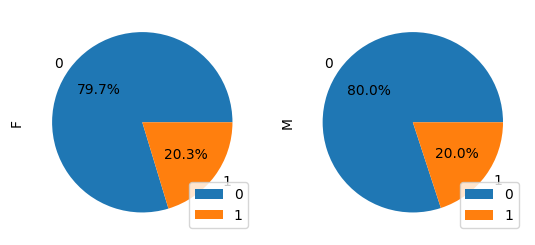

In [ ]:
data.groupby(['No-show', 'Gender']).size().unstack().plot(kind='pie',subplots=True, autopct='%1.1f%%')
plt.show()

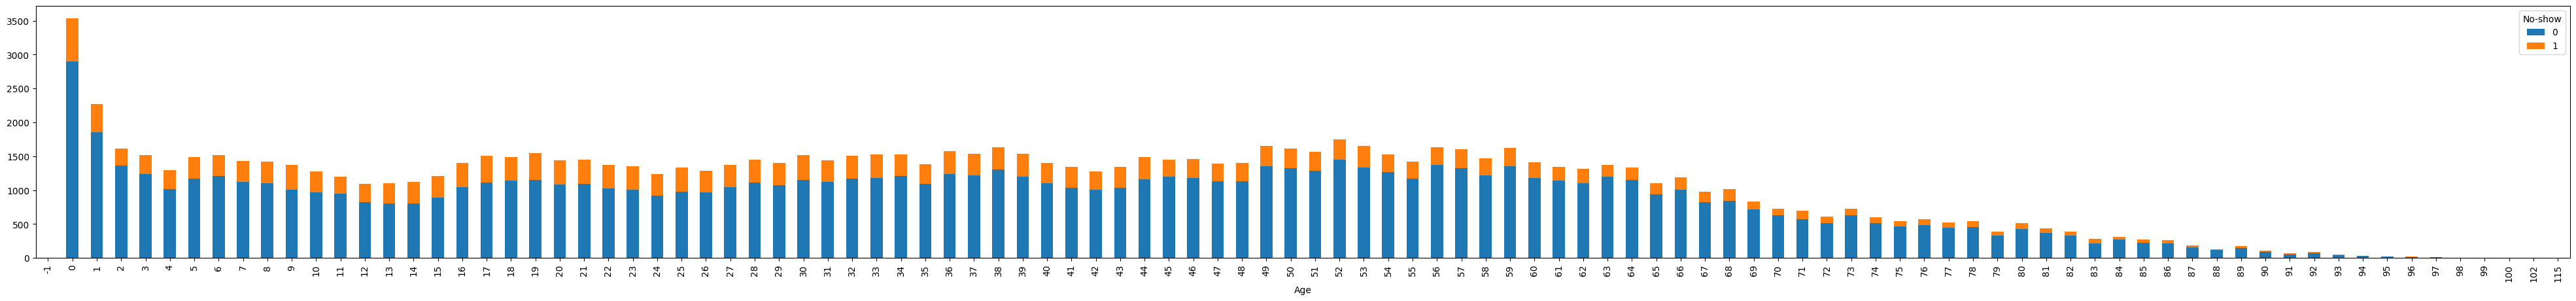

In [ ]:
data.groupby(['Age','No-show']).size().unstack().plot(kind='bar', figsize=(50,5), stacked = 'True')
plt.show()

In [ ]:
#data.groupby(['Age','No-show']).size().unstack().plot(kind='pie', subplots=True, autopct='%1.1f%%')
#plt.show()

In [ ]:
#data['Age bin'] = pd.qcut(data['Age'], q=3, labels=False)

In [ ]:
from sklearn.cluster import KMeans
x = data[['Age','No-show']].copy()

Text(0, 0.5, 'Inertia')

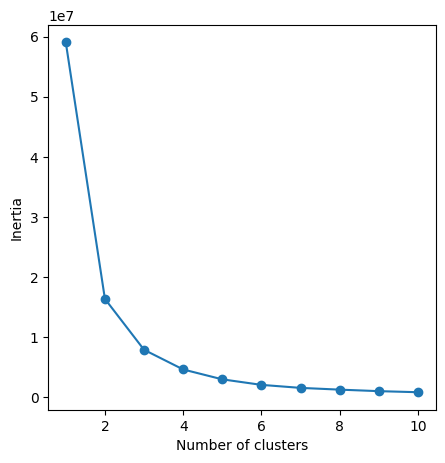

In [ ]:
SSE = []
for cluster in range(1,11):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(x)
    SSE.append(kmeans.inertia_)# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,11), 'SSE':SSE})
plt.figure(figsize=(5, 5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
kmeans = KMeans(3)
kmeans.fit(x)
clusters = x.copy()
clusters['cluster_pred']=kmeans.fit_predict(x)

In [ ]:
clusters

,Age,No-show,cluster_pred
0,62,0,1
1,56,0,1
2,62,0,1
3,8,0,2
4,56,0,1
...,...,...,...
110522,56,0,1
110523,51,0,1
110524,21,0,2
110525,38,0,0


In [ ]:
data = pd.concat([data, clusters['cluster_pred'].rename("Age bin")], axis=1)

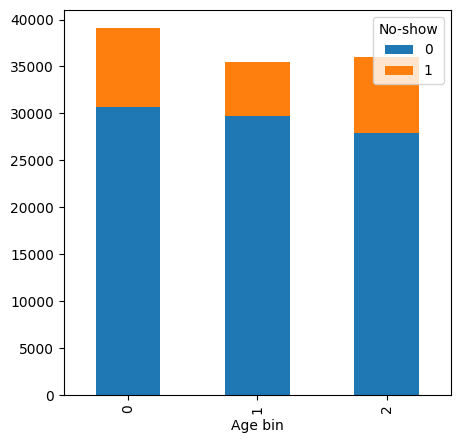

In [ ]:
data.groupby(['Age bin','No-show']).size().unstack().plot(kind='bar', figsize=(5,5), stacked = 'True')
plt.show()

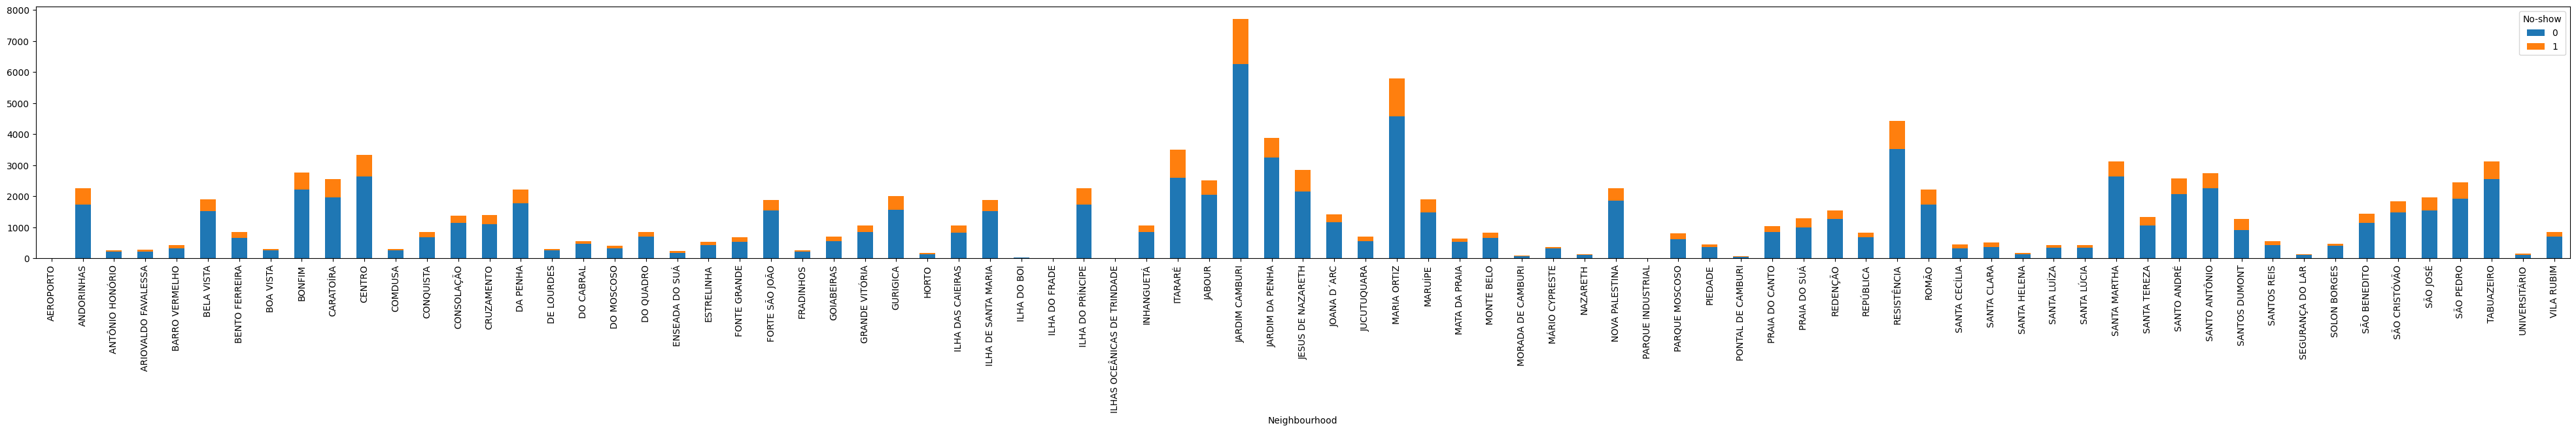

In [ ]:
data.groupby(['Neighbourhood','No-show']).size().unstack().plot(kind='bar', figsize=(50,5), stacked = 'True')
plt.show()

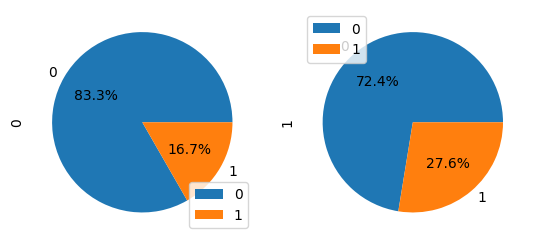

In [ ]:
data.groupby(['No-show','SMS_received']).size().unstack().plot(kind='pie',subplots=True, autopct='%1.1f%%')
plt.show()

In [ ]:
data['PatientId'].duplicated().any()

True

In [ ]:
data['AppointmentDay'].value_counts()

AppointmentDay
2016-06-06T00:00:00Z    4692
2016-05-16T00:00:00Z    4613
2016-05-09T00:00:00Z    4520
2016-05-30T00:00:00Z    4514
2016-06-08T00:00:00Z    4479
2016-05-11T00:00:00Z    4474
2016-06-01T00:00:00Z    4464
2016-06-07T00:00:00Z    4416
2016-05-12T00:00:00Z    4394
2016-05-02T00:00:00Z    4376
2016-05-18T00:00:00Z    4373
2016-05-17T00:00:00Z    4372
2016-06-02T00:00:00Z    4310
2016-05-10T00:00:00Z    4308
2016-05-31T00:00:00Z    4279
2016-05-05T00:00:00Z    4273
2016-05-19T00:00:00Z    4270
2016-05-03T00:00:00Z    4256
2016-05-04T00:00:00Z    4168
2016-06-03T00:00:00Z    4090
2016-05-24T00:00:00Z    4009
2016-05-13T00:00:00Z    3987
2016-05-25T00:00:00Z    3909
2016-05-06T00:00:00Z    3879
2016-05-20T00:00:00Z    3828
2016-04-29T00:00:00Z    3235
2016-05-14T00:00:00Z      39
Name: count, dtype: int64

In [ ]:
data['Appointment Day'] = pd.to_datetime(data['AppointmentDay']).dt.tz_localize(None)
data['Appointment_Date'] = data['Appointment Day'].dt.day
data['Appointment_Month'] = data['Appointment Day'].dt.month
#data['Appointment_Year'] = data['Appointment Day'].dt.year
data['Appointment_DOW'] = data['Appointment Day'].dt.day_name()

In [ ]:
data['Scheduled Day'] = pd.to_datetime(data['ScheduledDay']).dt.tz_localize(None)
data['Scheduled_Date'] = data['Scheduled Day'].dt.day
data['Scheduled_Month'] = data['Scheduled Day'].dt.month
#data['Scheduled_Year'] = data['Scheduled Day'].dt.year
data['Scheduled_DOW'] = data['Scheduled Day'].dt.day_name()

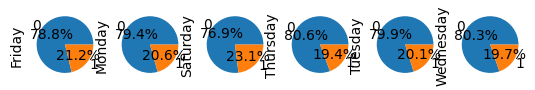

In [ ]:
data.groupby(['No-show','Appointment_DOW']).size().unstack().plot(kind='pie',subplots=True, legend= False, autopct='%1.1f%%')
plt.show()

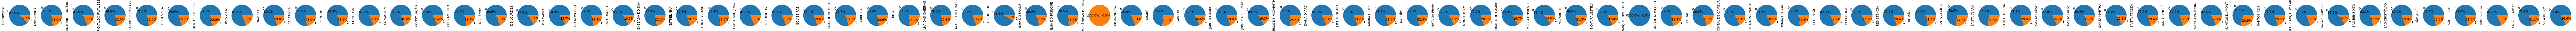

In [ ]:
data.groupby(['No-show','Neighbourhood']).size().unstack().plot(kind='pie',subplots=True, legend= False, autopct='%1.1f%%', figsize=(150,5))
plt.show()

In [ ]:
data['Scheduled Ahead'] =  (data['Appointment Day'] - data['Scheduled Day']).dt.days + 1

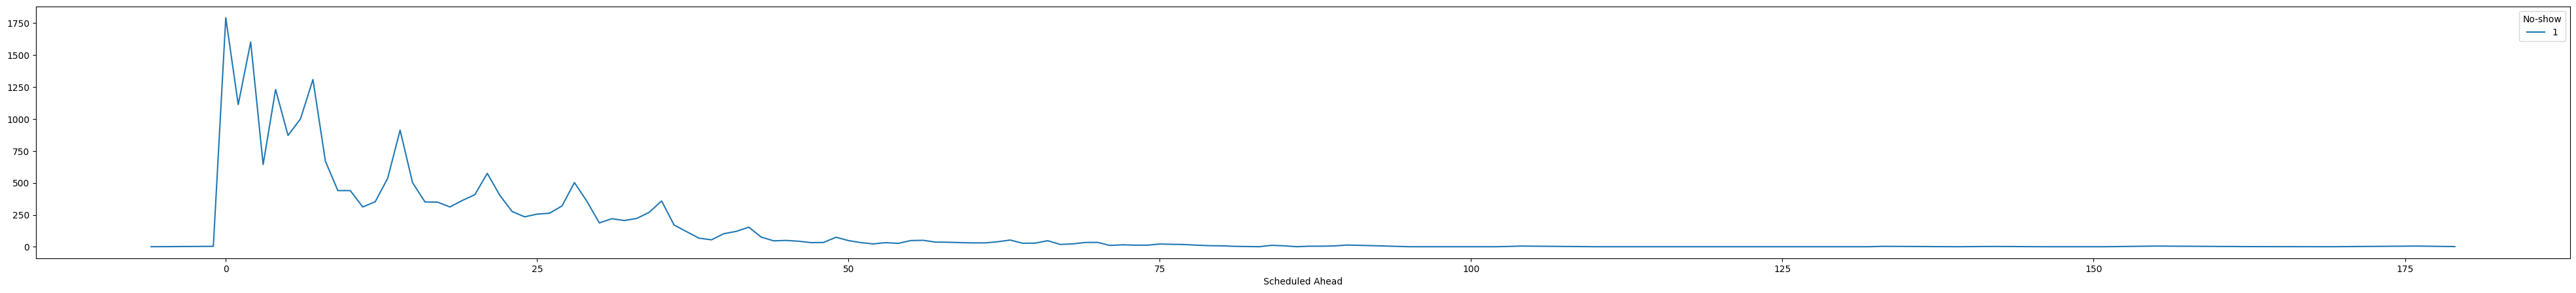

In [ ]:
data[data['No-show'] == 1].groupby(['Scheduled Ahead','No-show']).size().unstack().plot(kind='line', figsize=(50,5), stacked = 'True')
plt.show()

In [ ]:
data[data['No-show'] == 1]['No-show'].groupby(data['Scheduled Ahead']).value_counts().head(15)

Scheduled Ahead  No-show
-6               1             1
-1               1             4
 0               1          1792
 1               1          1113
 2               1          1602
 3               1           644
 4               1          1231
 5               1           872
 6               1          1001
 7               1          1309
 8               1           670
 9               1           440
 10              1           440
 11              1           312
 12              1           353
Name: count, dtype: int64

In [ ]:
print("Minimum age:", data['Age'].min())
print("Maximum age:", data['Age'].max())

Minimum age: -1
Maximum age: 115


In [ ]:
data_df = data[data['Age'] >= 0]

In [ ]:
data_df = data_df[data_df['Scheduled Ahead'] >= 0]

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110521 entries, 0 to 110526
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   PatientId          110521 non-null  float64       
 1   AppointmentID      110521 non-null  int64         
 2   Gender             110521 non-null  object        
 3   ScheduledDay       110521 non-null  object        
 4   AppointmentDay     110521 non-null  object        
 5   Age                110521 non-null  int64         
 6   Neighbourhood      110521 non-null  object        
 7   Scholarship        110521 non-null  int64         
 8   Hipertension       110521 non-null  int64         
 9   Diabetes           110521 non-null  int64         
 10  Alcoholism         110521 non-null  int64         
 11  Handcap            110521 non-null  int64         
 12  SMS_received       110521 non-null  int64         
 13  No-show            110521 non-null  int64        

In [ ]:
data_df.shape

(110521, 24)

In [ ]:
data_df = data_df.drop(columns=['ScheduledDay', 'AppointmentDay','Appointment Day','Scheduled Day','Age'])

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110521 entries, 0 to 110526
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   PatientId          110521 non-null  float64
 1   AppointmentID      110521 non-null  int64  
 2   Gender             110521 non-null  object 
 3   Neighbourhood      110521 non-null  object 
 4   Scholarship        110521 non-null  int64  
 5   Hipertension       110521 non-null  int64  
 6   Diabetes           110521 non-null  int64  
 7   Alcoholism         110521 non-null  int64  
 8   Handcap            110521 non-null  int64  
 9   SMS_received       110521 non-null  int64  
 10  No-show            110521 non-null  int64  
 11  Age bin            110521 non-null  int32  
 12  Appointment_Date   110521 non-null  int32  
 13  Appointment_Month  110521 non-null  int32  
 14  Appointment_DOW    110521 non-null  object 
 15  Scheduled_Date     110521 non-null  int32  
 16  Schedul

In [ ]:
# Create a contingency table
contingency_table_gender = pd.crosstab(data_df['Gender'], data_df['No-show'], normalize='index').round(4)*100
contingency_table_neigh = pd.crosstab(data_df['Neighbourhood'], data_df['No-show'], normalize='index').round(4)*100
contingency_table_sch = pd.crosstab(data_df['Scholarship'], data_df['No-show'], normalize='index').round(4)*100
contingency_table_hyper = pd.crosstab(data_df['Hipertension'], data_df['No-show'], normalize='index').round(4)*100
contingency_table_diabetes = pd.crosstab(data_df['Diabetes'], data_df['No-show'], normalize='index').round(4)*100
contingency_table_Alc = pd.crosstab(data_df['Alcoholism'], data_df['No-show'], normalize='index').round(4)*100
contingency_table_handicap = pd.crosstab(data_df['Handcap'], data_df['No-show'], normalize='index').round(4)*100
contingency_table_sms = pd.crosstab(data_df['SMS_received'], data_df['No-show'], normalize='index').round(4)*100
contingency_table_age = pd.crosstab(data_df['Age bin'], data_df['No-show'], normalize='index').round(4)*100
contingency_table_month = pd.crosstab(data_df['Appointment_Month'], data_df['No-show'], normalize='index').round(4)*100
contingency_table_date = pd.crosstab(data_df['Appointment_Date'], data_df['No-show'], normalize='index').round(4)*100
contingency_table_dow = pd.crosstab(data_df['Appointment_DOW'], data_df['No-show'], normalize='index').round(4)*100
contingency_table_ahead = pd.crosstab(data_df['Scheduled Ahead'], data_df['No-show'], normalize='index').round(4)*100

#contingency_table_gender.head(10)

In [ ]:
contingency_table_ahead.unstack().head(50)

No-show  Scheduled Ahead
0        0                  95.35
         1                  78.65
         2                  76.18
         3                  76.47
         4                  76.73
         5                  73.39
         6                  75.20
         7                  73.32
         8                  71.27
         9                  72.59
         10                 68.37
         11                 68.39
         12                 68.34
         13                 68.13
         14                 68.66
         15                 66.60
         16                 69.50
         17                 68.38
         18                 69.44
         19                 65.23
         20                 65.63
         21                 69.10
         22                 65.56
         23                 66.42
         24                 62.22
         25                 59.81
         26                 64.02
         27                 68.41
         28            

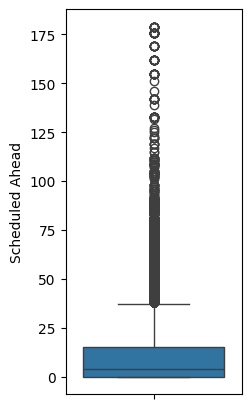

In [ ]:
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
sns.boxplot(data_df['Scheduled Ahead'])
plt.show()

In [ ]:
percentile25 = data_df['Scheduled Ahead'].quantile(0.25)
percentile75 = data_df['Scheduled Ahead'].quantile(0.75)
iqr = percentile75 - percentile25

In [ ]:
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

In [ ]:
print(upper_limit)
print(lower_limit)

37.5
-22.5


In [ ]:
def perform_chi_square_test(contingency_table, col):
# Perform the Chi-square test
  chi2, p_value, dof, expected = chi2_contingency(contingency_table)


# Interpret the results based on the p-value and a significance level of 0.05
  alpha = 0.05  # Significance level
  #print("\nConclusion")
  if p_value < alpha:
    res = "Yes"
  else:
    res = "No"

  row = [col, chi2, p_value, dof, res]
  chi_square_results.loc[len(chi_square_results)] = row


In [ ]:
chi_square_results = pd.DataFrame(columns=['Feature', 'Chi-square value', 'P-value', 'Degrees of Freedom','Significant relationship with No-show'])
perform_chi_square_test(contingency_table_gender,'Gender')
perform_chi_square_test(contingency_table_neigh,'Neighbourhood')
perform_chi_square_test(contingency_table_sch,'Scholarship')
perform_chi_square_test(contingency_table_hyper,'Hipertension')
perform_chi_square_test(contingency_table_diabetes,'Diabetes')
perform_chi_square_test(contingency_table_Alc,'Alcoholism')
perform_chi_square_test(contingency_table_handicap,'Handcap')
perform_chi_square_test(contingency_table_sms,'SMS_received')
perform_chi_square_test(contingency_table_age,'Age bin')
perform_chi_square_test(contingency_table_month,'Appointment_Month')
perform_chi_square_test(contingency_table_date,'Appointment_Date')
perform_chi_square_test(contingency_table_dow,'Appointment_DOW')
perform_chi_square_test(contingency_table_ahead,'Scheduled Ahead')

In [ ]:
display(chi_square_results)

,Feature,Chi-square value,P-value,Degrees of Freedom,Significant relationship with No-show
0,Gender,0.000000,1.000000e+00,1,No
1,Neighbourhood,463.423960,2.353754e-55,80,Yes
2,Scholarship,0.253766,6.144359e-01,1,No
3,Hipertension,0.218743,6.399991e-01,1,No
4,Diabetes,0.059660,8.070348e-01,1,No
5,Alcoholism,0.000000,1.000000e+00,1,No
6,Handcap,8.413161,7.756357e-02,4,No
7,SMS_received,2.826067,9.274522e-02,1,No
8,Age bin,1.491236,4.744411e-01,2,No
9,Appointment_Month,0.170863,9.181162e-01,2,No


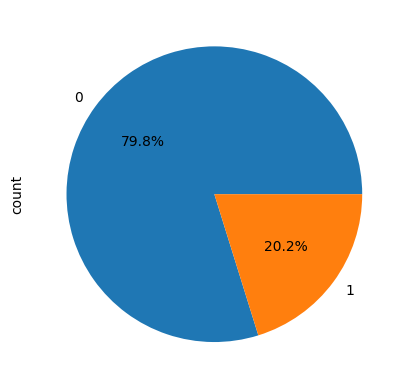

In [ ]:
data['No-show'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

In [ ]:
encoder = TargetEncoder()
data_df['Neighbourhood'] = encoder.fit_transform(data_df['Neighbourhood'], data_df['No-show'])
data_df['Gender'] = data_df['Gender'].map({'M': 1, 'F': 0})
data_df['Scheduled_DOW'] = encoder.fit_transform(data_df['Scheduled_DOW'], data_df['No-show'])
data_df['Appointment_DOW'] = encoder.fit_transform(data_df['Appointment_DOW'], data_df['No-show'])

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110521 entries, 0 to 110526
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   PatientId          110521 non-null  float64
 1   AppointmentID      110521 non-null  int64  
 2   Gender             110521 non-null  int64  
 3   Neighbourhood      110521 non-null  float64
 4   Scholarship        110521 non-null  int64  
 5   Hipertension       110521 non-null  int64  
 6   Diabetes           110521 non-null  int64  
 7   Alcoholism         110521 non-null  int64  
 8   Handcap            110521 non-null  int64  
 9   SMS_received       110521 non-null  int64  
 10  No-show            110521 non-null  int64  
 11  Age bin            110521 non-null  int32  
 12  Appointment_Date   110521 non-null  int32  
 13  Appointment_Month  110521 non-null  int32  
 14  Appointment_DOW    110521 non-null  float64
 15  Scheduled_Date     110521 non-null  int32  
 16  Schedul

In [ ]:
for size in [np.uint8, np.uint16, np.uint32]:
    print(np.iinfo(size))

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for uint16
---------------------------------------------------------------
min = 0
max = 65535
---------------------------------------------------------------

Machine parameters for uint32
---------------------------------------------------------------
min = 0
max = 4294967295
---------------------------------------------------------------



In [ ]:
def shrink_ints(data_df):
    #display(df.dtypes)
    mapping = {}
    for col in data_df.dtypes[data_df.dtypes=='int64'].index:
        max_ = data_df[col].max()

        min_ = data_df[col].min()
        #print(col, max_, min_)
        if min_ < 0:
            continue
        if max_ < 255:
            mapping = 'int8'
        elif max_ < 65_535:
            mapping = 'int16'
        elif max_ <  4294967295:
            mapping = 'int32'
        #print(col, mapping)
        data_df[col]=data_df[col].astype(mapping)

In [ ]:
data_df.dtypes[data_df.dtypes=='int64']

AppointmentID      int64
Scholarship        int64
Hipertension       int64
Diabetes           int64
Alcoholism         int64
Handcap            int64
SMS_received       int64
No-show            int64
Scheduled Ahead    int64
dtype: object

In [ ]:
data_df.pipe(shrink_ints)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110521 entries, 0 to 110526
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   PatientId          110521 non-null  float64
 1   AppointmentID      110521 non-null  int32  
 2   Gender             110521 non-null  int8   
 3   Neighbourhood      110521 non-null  float64
 4   Scholarship        110521 non-null  int8   
 5   Hipertension       110521 non-null  int8   
 6   Diabetes           110521 non-null  int8   
 7   Alcoholism         110521 non-null  int8   
 8   Handcap            110521 non-null  int8   
 9   SMS_received       110521 non-null  int8   
 10  No-show            110521 non-null  int8   
 11  Age bin            110521 non-null  int32  
 12  Appointment_Date   110521 non-null  int32  
 13  Appointment_Month  110521 non-null  int32  
 14  Appointment_DOW    110521 non-null  float64
 15  Scheduled_Date     110521 non-null  int32  
 16  Schedul

In [ ]:
from scipy import stats
import numpy as np

# Calculate the z-scores
z_scores = stats.zscore(data_df)

# Print the z-scores
z_scores

# Convert the z-scores to absolute values
abs_z_scores = np.abs(z_scores)

# Select data points with a z-scores above or below 3
filtered_entries = (abs_z_scores < 3).all(axis=1)

# Filter the dataset
filtered_df = data_df[filtered_entries]

# Print the filtered DataFrame
filtered_df.info()
filtered_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 82879 entries, 0 to 110526
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PatientId          82879 non-null  float64
 1   AppointmentID      82879 non-null  int32  
 2   Gender             82879 non-null  int8   
 3   Neighbourhood      82879 non-null  float64
 4   Scholarship        82879 non-null  int8   
 5   Hipertension       82879 non-null  int8   
 6   Diabetes           82879 non-null  int8   
 7   Alcoholism         82879 non-null  int8   
 8   Handcap            82879 non-null  int8   
 9   SMS_received       82879 non-null  int8   
 10  No-show            82879 non-null  int8   
 11  Age bin            82879 non-null  int32  
 12  Appointment_Date   82879 non-null  int32  
 13  Appointment_Month  82879 non-null  int32  
 14  Appointment_DOW    82879 non-null  float64
 15  Scheduled_Date     82879 non-null  int32  
 16  Scheduled_Month    82879 n

,PatientId,AppointmentID,Gender,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Age bin,Appointment_Date,Appointment_Month,Appointment_DOW,Scheduled_Date,Scheduled_Month,Scheduled_DOW,Scheduled Ahead
0,2.987250e+13,5642903,0,0.162755,0,1,0,0,0,0,0,1,29,4,0.212261,29,4,0.205498,0
1,5.589978e+14,5642503,1,0.162755,0,0,0,0,0,0,0,1,29,4,0.212261,29,4,0.205498,0
2,4.262962e+12,5642549,0,0.170807,0,0,0,0,0,0,0,1,29,4,0.212261,29,4,0.205498,0
3,8.679512e+11,5642828,0,0.174120,0,0,0,0,0,0,0,2,29,4,0.212261,29,4,0.205498,0
5,9.598513e+13,5626772,0,0.171257,0,1,0,0,0,0,0,1,29,4,0.212261,27,4,0.200998,2


In [ ]:
train_data, test_data = train_test_split(filtered_df, test_size=0.2, stratify=filtered_df['No-show'], random_state=42)

In [ ]:
train_value_counts = train_data['No-show'].value_counts(normalize=True) * 100
test_value_counts = test_data['No-show'].value_counts(normalize=True) * 100

train_value_counts = train_value_counts.round(1)
test_value_counts = test_value_counts.round(1)

print("Training set 'No-show' value counts (in %):")
display(train_value_counts)

print("\nTest set 'No-show' value counts (in %):")
display(test_value_counts)

Training set 'No-show' value counts (in %):


No-show
0    79.8
1    20.2
Name: proportion, dtype: float64


Test set 'No-show' value counts (in %):


No-show
0    79.8
1    20.2
Name: proportion, dtype: float64

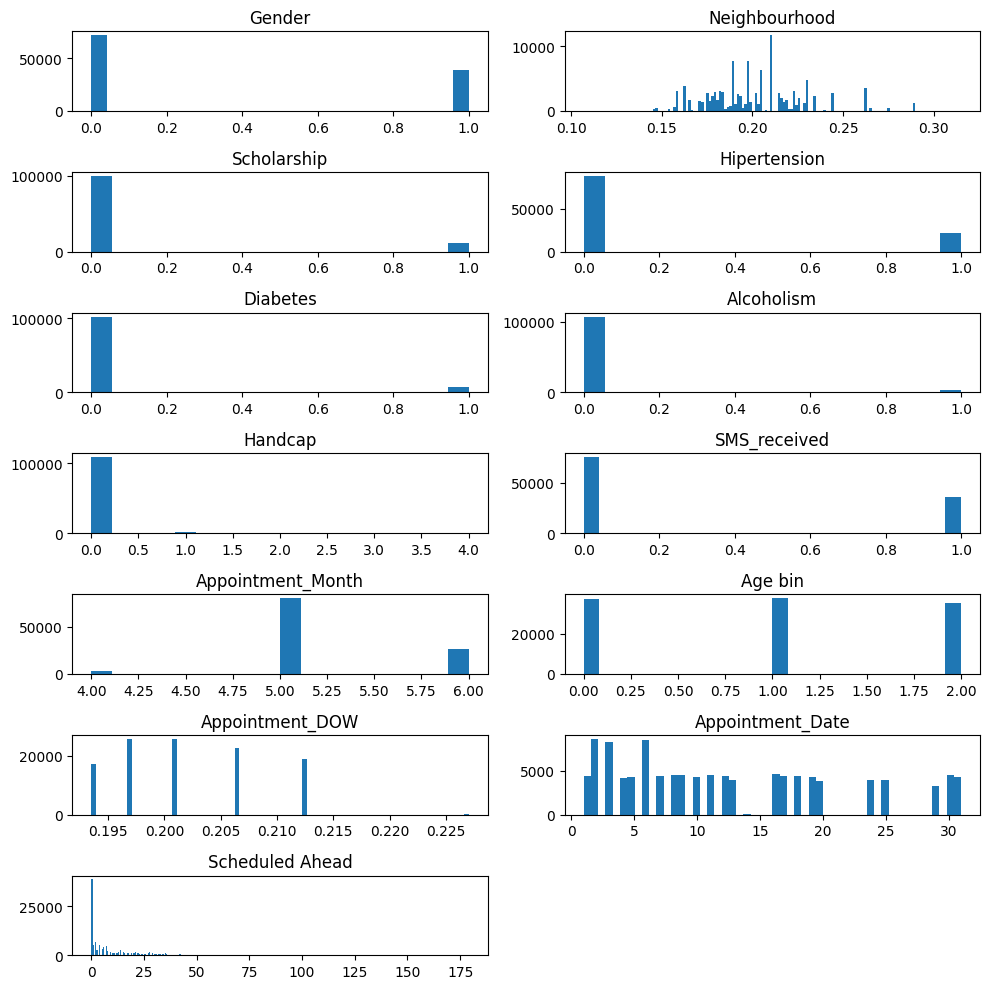

In [ ]:
# Create a 4x2 grid of subplots
fig, ax = plt.subplots(7, 2,figsize=(10, 10))

# Plot histograms on each subplot
ax[0, 0].hist(data_df['Gender'], bins="auto")
ax[0, 1].hist(data_df['Neighbourhood'], bins="auto")
ax[1, 0].hist(data_df['Scholarship'], bins="auto")
ax[1, 1].hist(data_df['Hipertension'], bins="auto")
ax[2, 0].hist(data_df['Diabetes'], bins="auto")
ax[2, 1].hist(data_df['Alcoholism'], bins="auto")
ax[3, 0].hist(data_df['Handcap'], bins="auto")
ax[3, 1].hist(data_df['SMS_received'], bins="auto")
ax[4, 1].hist(data_df['Age bin'], bins="auto")
ax[4,0].hist(data_df['Appointment_Month'], bins="auto")
ax[5,1].hist(data_df['Appointment_Date'], bins="auto")
ax[5,0].hist(data_df['Appointment_DOW'], bins="auto")
ax[6,0].hist(data_df['Scheduled Ahead'], bins="auto")

# Set titles for each subplot
ax[0, 0].set_title('Gender')
ax[0, 1].set_title('Neighbourhood')
ax[1, 0].set_title('Scholarship')
ax[1, 1].set_title('Hipertension')
ax[2, 0].set_title('Diabetes')
ax[2, 1].set_title('Alcoholism')
ax[3, 0].set_title('Handcap')
ax[3, 1].set_title('SMS_received')
ax[4, 1].set_title('Age bin')
ax[4,0].set_title('Appointment_Month')
ax[5,1].set_title('Appointment_Date')
ax[5,0].set_title('Appointment_DOW')
ax[6,0].set_title('Scheduled Ahead')

# Remove the empty subplot in the last row and last column
fig.delaxes(ax[6, 1])

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()

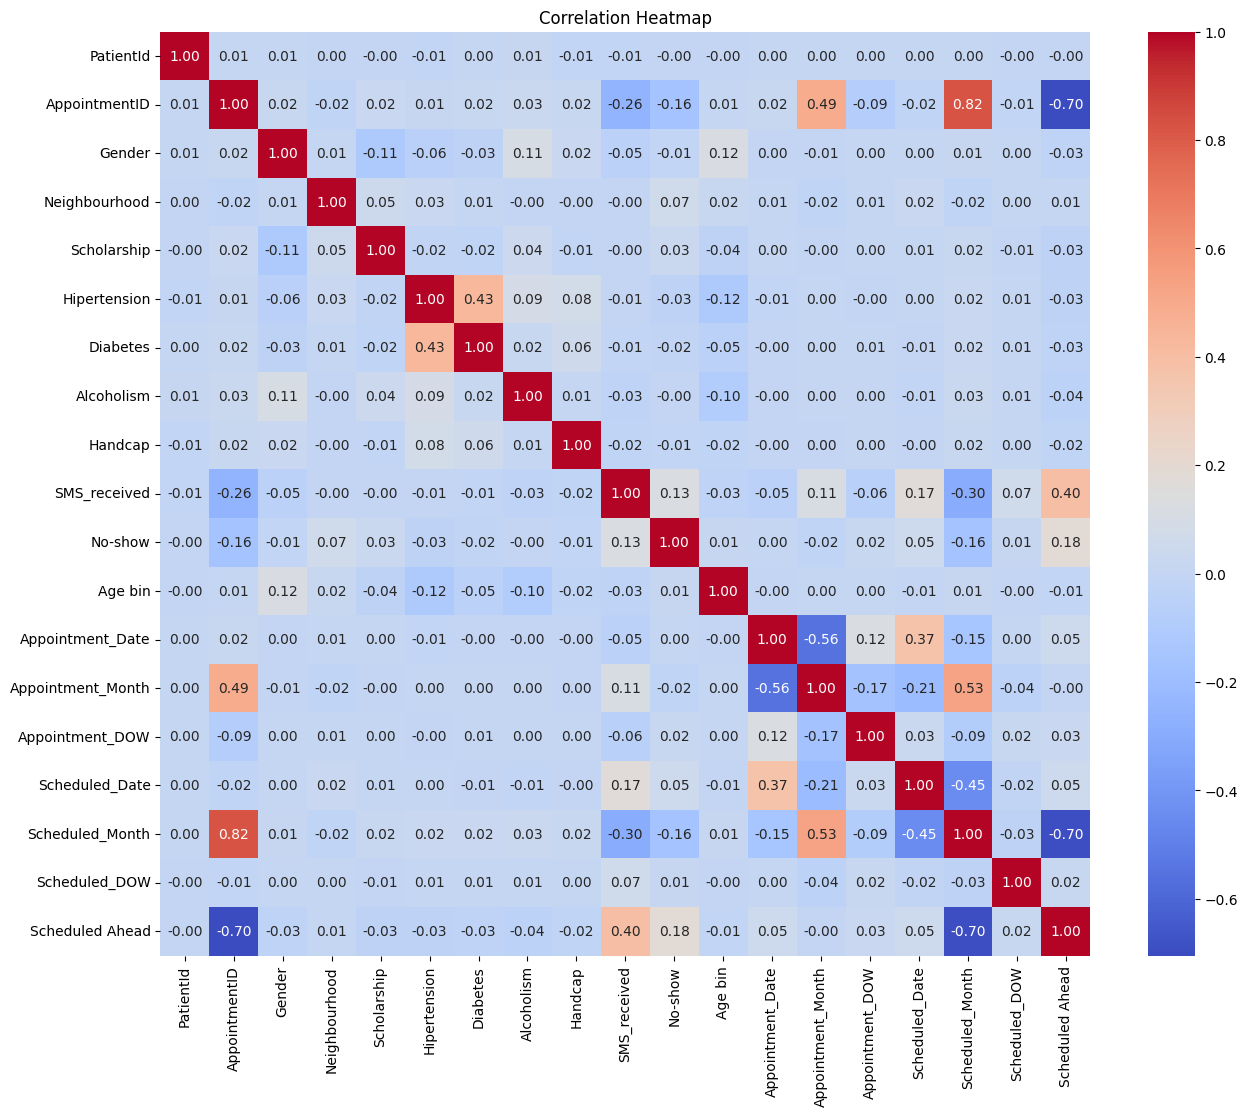

In [ ]:
corr_matrix = train_data.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()